## <u><center>LeanTaas Data Analysis for Operating Room Utilization</center></u>

### <u>Assumptions/Calculations:</u>

#####  Response time- time to reply on each action of the same parentid or Exchange request
##### 2. Surgeon and Room no. is unchanged for exchange cycle
##### 3. Transaction id is unique for each individual entry
##### 4. Rejection/denial Rate-100* no. of rejected request/(total no. of request)
##### 5. Approval Rate-100* no. of approved request/(total no. of request)
##### 6. I assume that there is either approve or reject of every echange request
##### 7. In Some exchange, starting transactions i.e. 'Request Entries' are missing and we are not validating the data
##### 8. approve_transfer,approve_request is considered as approved exchange
##### 9. deny_transfer,deny_request, deny_realease is considered as denial exchange

#### List of used library- pandas, numpy, sqlalchemy ,matplotlib, datetime:

In [51]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from matplotlib import pyplot
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import seaborn as sns

In [52]:
disk_engine = create_engine('sqlite:///LeanTaaSTestDB.db')

### Explore, Clean and Prepare Data

In [53]:
df_txn_all = pd.read_sql_query('SELECT * from exchange_transactions', disk_engine)
df_txn_all.head(2)
#df_txn_all.to_csv('LeanTass1.csv')

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
0,2c91808267d2ea5301682f73e9a1093e,None,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32.000000,2019-07-01 00:00:00.000000,07:30:00,19:00:00,MRAH OR 03,CENTER
1,2c91808267d2ea5301683984e52b0bfb,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER


#### Understanding of various features(columns) of the dataset:

In [4]:
df_txn_all.describe()

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
count,6965,4176,6965,6965,6965,6965,6965,6965,6965,4376,6965
unique,6935,2772,9,275,357,6823,65,64,76,95,7
top,2c9180826bda4bbe016bfb17f1fe0e0a,2c9180826bda4bbe016bfb17f1fe0e0a,MARK_UPDATED,Debra Selman,Daniel Finney,2019-07-09 11:13:53.000000,2019-06-28 00:00:00.000000,07:30:00,19:00:00,MRHOR 03,MRAH OR
freq,4,4,2576,485,135,4,189,2054,1696,117,2205


In [54]:
df_txn_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 11 columns):
transaction_id           6965 non-null object
parent_transaction_id    4176 non-null object
action                   6965 non-null object
scheduler                6965 non-null object
surgeon                  6965 non-null object
created_datetime         6965 non-null object
snapshot_date            6965 non-null object
start_time               6965 non-null object
end_time                 6965 non-null object
room_name                4376 non-null object
location                 6965 non-null object
dtypes: object(11)
memory usage: 598.7+ KB


#### Checking of surgeon duplication during the exchange transaction assumption#1

In [55]:
df_surg_dup = pd.read_sql_query('SELECT parent_transaction_id,count(distinct surgeon) cnt from exchange_transactions where parent_transaction_id is not null group by parent_transaction_id order by parent_transaction_id', disk_engine)
#print('The number of repeated transaction is ',df_surg_dup.cnt.sum()-df_surg_dup.parent_transaction_id.count())
print('The number of records with surgent count more than 1 for single Exchage cycle-',df_surg_dup[df_surg_dup['cnt']>1])
df_surg_dup.parent_transaction_id.value_counts()

The number of records with surgent count more than 1 for single Exchage cycle- Empty DataFrame
Columns: [parent_transaction_id, cnt]
Index: []


2c9180826c2b12fa016c48afe8770d7c    1
2c9180826abd7454016ac0a394f400c1    1
2c9180826ae1b1f5016ae5ae61a901ef    1
2c9180826c49ffa1016c538ed59f0b8d    1
2c9180826abd7454016ac6796add05dd    1
                                   ..
2c9180826aa811ea016abccc4ba60db9    1
2c9180826c01e38b016c1f9bbbc31127    1
2c9180826a51a332016a551f103c00bf    1
2c9180826ba0b46c016bb34189b8082a    1
2c9180826ae7994d016b0949e8190e39    1
Name: parent_transaction_id, Length: 2772, dtype: int64

#### Conclusion : No duplicate found

#### Checking duplicates based on transaction_id of assumption#3

In [56]:
n_duplicated = df_txn_all.duplicated(subset=['transaction_id']).sum()
print("There are {}/{} duplicated records.".format(n_duplicated, df_txn_all.shape[0]))

There are 30/6965 duplicated records.


#### The above analysis shows that there are 30 duplicate entries and to cross check the same using the sqlite data source

In [57]:
df_txn_dup = pd.read_sql_query('SELECT *,count(*) cnt from exchange_transactions group by transaction_id HAVING count(*)>1 order by transaction_id', disk_engine)
print('The number of repeated transaction is ',df_txn_dup.cnt.sum()-df_txn_dup.transaction_id.count())
#df_txn_dup[['transaction_id','cnt']].head()

The number of repeated transaction is  30


### Visulizing the duplicate transaction and their frequency

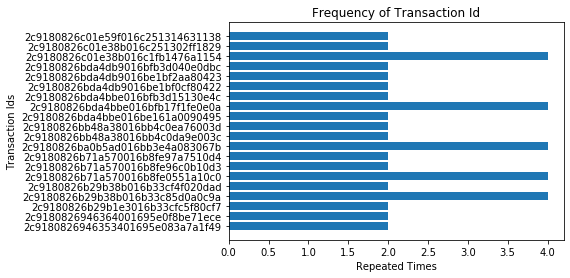

In [9]:
txn_id = df_txn_dup['transaction_id']
y_pos = np.arange(len(txn_id))
repeat = df_txn_dup['cnt']

plt.barh(y_pos, repeat, align='center', alpha=1)
plt.yticks(y_pos, txn_id)
plt.xlabel('Repeated Times')
plt.ylabel('Transaction Ids')
plt.title('Frequency of Transaction Id')
plt.show()

#### Conclusion: 30 duplicate transactions has to be removed 

In [58]:
df_no_dup = df_txn_all.drop(df_txn_all.index[df_txn_all.transaction_id.duplicated()], axis=0)
print("{} records after dropping duplicated.".format(df_no_dup.shape[0]))
#df_txn_all.to_csv('LeanTass.csv')

6935 records after dropping duplicated.


In [59]:
df_no_dup.parent_transaction_id.fillna(df_no_dup.transaction_id, inplace = True) 
df_no_dup.head(2)

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
0,2c91808267d2ea5301682f73e9a1093e,2c91808267d2ea5301682f73e9a1093e,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32.000000,2019-07-01 00:00:00.000000,07:30:00,19:00:00,MRAH OR 03,CENTER
1,2c91808267d2ea5301683984e52b0bfb,2c91808267d2ea5301683984e52b0bfb,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER


#### Surgeon wise Exchange Reuest analysis

In [118]:
print('Total Exchange Requests:',df_no_dup.surgeon.count())#1179

Total Exchange Requests: 6935


In [127]:
print('Total number of Unique request by Surgeon ',len(df_no_dup['surgeon'].unique().tolist()))

Total number of Unique request by Surgeon  357


In [126]:
df1=df_no_dup
print(len(df1[df1['count']>50].surgeon.unique().tolist()),'Surgeons have requested more than 50 times.')

15 Surgeons have requested more than 50 times.


Daniel Finney        135
Gordon Dombrowski    108
Scott Nash            99
Holly Firkins         93
Richard Smith         90
Dorothy Shaver        89
Twanna May            71
Richard Estes         69
Dulce Graves          68
Marty Flores          66
Berneice Rodregez     63
Manuel Winfrey        61
Joyce Belair          60
Gregory Hunt          54
Charles Mcdonald      53
Name: surgeon, dtype: int64


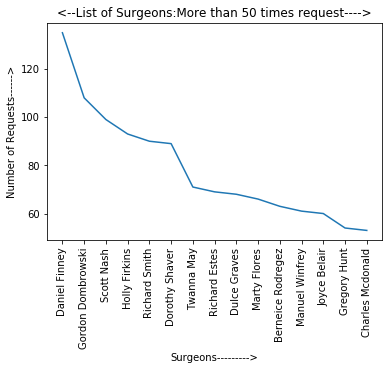

In [131]:
print(df1[df1['count']>50].surgeon.value_counts())
plt.xticks(rotation=90)
plt.xlabel('Surgeons--------->')
plt.ylabel('Number of Requests------>')
plt.title('<--List of Surgeons:More than 50 times request---->')
plt.plot(df1[df1['count']>50].surgeon.value_counts())
plt.show()

#### Calculating response time:
##### 1. Creating a new colum named prev_datetime
##### 2. Creating a new column to hold the differnce of created_datetime and prev_datetime as response_time 

In [60]:
df_no_dup['prev_datetime']=df_no_dup.groupby('parent_transaction_id')['created_datetime'].shift(1)
df_no_dup.sort_values(['parent_transaction_id','created_datetime'],inplace=True)
df_req=df_no_dup
df_req.head(5)

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location,prev_datetime
0,2c91808267d2ea5301682f73e9a1093e,2c91808267d2ea5301682f73e9a1093e,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32.000000,2019-07-01 00:00:00.000000,07:30:00,19:00:00,MRAH OR 03,CENTER,NaN
7,2c91808267d2eb4b01682fb1563009f8,2c91808267d2ea5301682f73e9a1093e,MARK_UPDATED,Mary White,Bryan Neer,2019-01-15 14:59:38.000000,2019-07-01 00:00:00.000000,07:30:00,19:00:00,MRAH OR 03,CENTER,2019-01-15 13:52:32.000000
1,2c91808267d2ea5301683984e52b0bfb,2c91808267d2ea5301683984e52b0bfb,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER,NaN
27,2c918082683a181c01683d381d24004b,2c91808267d2ea5301683984e52b0bfb,APPROVE_TRANSFER,Daniel Bryant,Charles Mcdonald,2019-01-18 06:01:54.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER,2019-01-17 12:47:17.000000
28,2c918082683a181c01683d383c31004c,2c91808267d2ea5301683984e52b0bfb,MARK_UPDATED,Daniel Bryant,Charles Mcdonald,2019-01-18 06:02:02.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER,2019-01-18 06:01:54.000000


#### There is no previous time of the first transaction of every Exchange request , So removing that to get the response time 

In [61]:
df_final=df_req[df_req['prev_datetime'].notnull()]
df_final.head(5)

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location,prev_datetime
7,2c91808267d2eb4b01682fb1563009f8,2c91808267d2ea5301682f73e9a1093e,MARK_UPDATED,Mary White,Bryan Neer,2019-01-15 14:59:38.000000,2019-07-01 00:00:00.000000,07:30:00,19:00:00,MRAH OR 03,CENTER,2019-01-15 13:52:32.000000
27,2c918082683a181c01683d381d24004b,2c91808267d2ea5301683984e52b0bfb,APPROVE_TRANSFER,Daniel Bryant,Charles Mcdonald,2019-01-18 06:01:54.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER,2019-01-17 12:47:17.000000
28,2c918082683a181c01683d383c31004c,2c91808267d2ea5301683984e52b0bfb,MARK_UPDATED,Daniel Bryant,Charles Mcdonald,2019-01-18 06:02:02.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER,2019-01-18 06:01:54.000000
25,2c918082683a181c01683d3543ce0043,2c91808267d2ea53016839855a480bfc,APPROVE_TRANSFER,Daniel Bryant,Charles Mcdonald,2019-01-18 05:58:48.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MNOR 36,CENTER,2019-01-17 12:47:47.000000
26,2c918082683a181c01683d37cb130049,2c91808267d2ea53016839855a480bfc,MARK_UPDATED,Daniel Bryant,Charles Mcdonald,2019-01-18 06:01:33.000000,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MNOR 36,CENTER,2019-01-18 05:58:48.000000


### Creating a separate dataframe for request wise ,action wise analysis

In [62]:
df_resp_time=df_final[['transaction_id','parent_transaction_id','action','created_datetime','prev_datetime']]
df_resp_time.head(5)
#df_no_dup.loc[df_no_dup['response_datetime'].notnull(),['transaction_id','parent_transaction_id','action','created_datetime','response_datetime']]

,transaction_id,parent_transaction_id,action,created_datetime,prev_datetime
7,2c91808267d2eb4b01682fb1563009f8,2c91808267d2ea5301682f73e9a1093e,MARK_UPDATED,2019-01-15 14:59:38.000000,2019-01-15 13:52:32.000000
27,2c918082683a181c01683d381d24004b,2c91808267d2ea5301683984e52b0bfb,APPROVE_TRANSFER,2019-01-18 06:01:54.000000,2019-01-17 12:47:17.000000
28,2c918082683a181c01683d383c31004c,2c91808267d2ea5301683984e52b0bfb,MARK_UPDATED,2019-01-18 06:02:02.000000,2019-01-18 06:01:54.000000
25,2c918082683a181c01683d3543ce0043,2c91808267d2ea53016839855a480bfc,APPROVE_TRANSFER,2019-01-18 05:58:48.000000,2019-01-17 12:47:47.000000
26,2c918082683a181c01683d37cb130049,2c91808267d2ea53016839855a480bfc,MARK_UPDATED,2019-01-18 06:01:33.000000,2019-01-18 05:58:48.000000


### Response time calculation of every action/response

In [63]:
df_resp_time['response_time']=pd.to_datetime(df_resp_time['created_datetime'])-pd.to_datetime(df_resp_time['prev_datetime'])
df_resp_time['resp_time_min']=df_resp_time['response_time'].apply(lambda x: x/np.timedelta64(1,'m'))
df_resp_time.head(5)

,transaction_id,parent_transaction_id,action,created_datetime,prev_datetime,response_time,resp_time_min
7,2c91808267d2eb4b01682fb1563009f8,2c91808267d2ea5301682f73e9a1093e,MARK_UPDATED,2019-01-15 14:59:38.000000,2019-01-15 13:52:32.000000,01:07:06,67.100000
27,2c918082683a181c01683d381d24004b,2c91808267d2ea5301683984e52b0bfb,APPROVE_TRANSFER,2019-01-18 06:01:54.000000,2019-01-17 12:47:17.000000,17:14:37,1034.616667
28,2c918082683a181c01683d383c31004c,2c91808267d2ea5301683984e52b0bfb,MARK_UPDATED,2019-01-18 06:02:02.000000,2019-01-18 06:01:54.000000,00:00:08,0.133333
25,2c918082683a181c01683d3543ce0043,2c91808267d2ea53016839855a480bfc,APPROVE_TRANSFER,2019-01-18 05:58:48.000000,2019-01-17 12:47:47.000000,17:11:01,1031.016667
26,2c918082683a181c01683d37cb130049,2c91808267d2ea53016839855a480bfc,MARK_UPDATED,2019-01-18 06:01:33.000000,2019-01-18 05:58:48.000000,00:02:45,2.750000


In [79]:
df_resp_time['parent_transaction_id'].count()

4162

### Number of Exchange transactions with average response time less than 10 mins

In [76]:
df_resp_time[df_resp_time['resp_time_min']<=10].parent_transaction_id.count()

2302

#### Finding: out of 4162 the Exchange transactions 2302 responses has less than 10 minutes response time

#### Creating a Day column for Day wise analysis

In [64]:
df_resp_time['prev_date'] = pd.to_datetime(df_resp_time['prev_datetime']).dt.strftime('%A')
#df_resp_time['day'] = pd.to_datetime(df_resp_time['prev_datetime']).dt.strftime('%d')
df_resp_time.head(5)
#df_resp_time.to_csv('LeanTaas.csv')

,transaction_id,parent_transaction_id,action,created_datetime,prev_datetime,response_time,resp_time_min,prev_date
7,2c91808267d2eb4b01682fb1563009f8,2c91808267d2ea5301682f73e9a1093e,MARK_UPDATED,2019-01-15 14:59:38.000000,2019-01-15 13:52:32.000000,01:07:06,67.100000,Tuesday
27,2c918082683a181c01683d381d24004b,2c91808267d2ea5301683984e52b0bfb,APPROVE_TRANSFER,2019-01-18 06:01:54.000000,2019-01-17 12:47:17.000000,17:14:37,1034.616667,Thursday
28,2c918082683a181c01683d383c31004c,2c91808267d2ea5301683984e52b0bfb,MARK_UPDATED,2019-01-18 06:02:02.000000,2019-01-18 06:01:54.000000,00:00:08,0.133333,Friday
25,2c918082683a181c01683d3543ce0043,2c91808267d2ea53016839855a480bfc,APPROVE_TRANSFER,2019-01-18 05:58:48.000000,2019-01-17 12:47:47.000000,17:11:01,1031.016667,Thursday
26,2c918082683a181c01683d37cb130049,2c91808267d2ea53016839855a480bfc,MARK_UPDATED,2019-01-18 06:01:33.000000,2019-01-18 05:58:48.000000,00:02:45,2.750000,Friday


#### Actionwise avergage response time in minutes:

In [66]:
df=df_resp_time.groupby('action').resp_time_min.mean()
df.head(10)

action
APPROVE_REQUEST      643.711060
APPROVE_TRANSFER     263.992654
DENY_RELEASE         310.790741
DENY_REQUEST        1496.534217
DENY_TRANSFER       5256.573333
MARK_UPDATED         284.758467
RELEASE             -249.774060
REQUEST             -313.086020
TRANSFER            -297.401732
Name: resp_time_min, dtype: float64

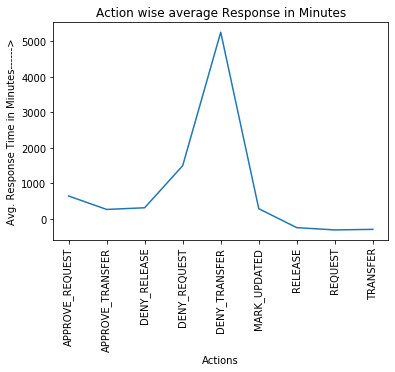

In [67]:
plt.plot(df_resp_time.groupby('action').resp_time_min.mean())
#plt.yticks(y_pos, txn_id)
plt.xticks(rotation=90)
plt.xlabel('Actions')
plt.ylabel('Avg. Response Time in Minutes------>')
plt.title('Action wise average Response in Minutes')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

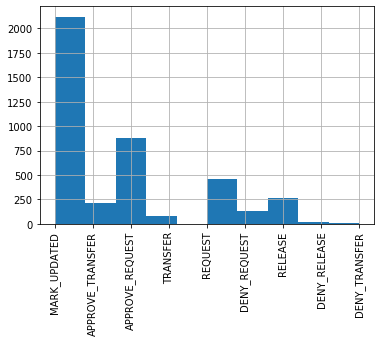

In [68]:
df_resp_time['action'].hist()
plt.xticks(rotation=90)

### Daywise response analysis

In [69]:
df=df_resp_time.groupby('prev_date').resp_time_min.mean()
df.head(10)

prev_date
Friday        279.634291
Monday        175.439436
Saturday     2569.953333
Sunday       2301.533333
Thursday      424.880628
Tuesday       217.067741
Wednesday     344.446315
Name: resp_time_min, dtype: float64

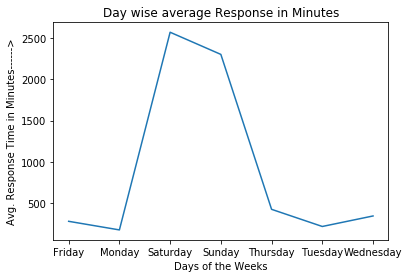

In [70]:
plt.plot(df_resp_time.groupby('prev_date').resp_time_min.mean())
#plt.yticks(y_pos, txn_id)
plt.xlabel('Days of the Weeks')
plt.ylabel('Avg. Response Time in Minutes------>')
plt.title('Day wise average Response in Minutes')
plt.show()

### Approval and Rejection rate

In [22]:
#df_rate = pd.read_sql_query('SELECT ifnull(parent_transaction_id,transaction_id) pid, action from exchange_transactions where action in ("APPROVE_REQUEST","DENY_TRANSFER")', disk_engine)
df_appr = pd.read_sql_query('select ifnull(parent_transaction_id,transaction_id) pid,action, min(created_datetime) start_dt,max(created_datetime)  end_dt from exchange_transactions where action not in ("TRANSFER","RELEASE","MARK_UPDATED") Group By ifnull(parent_transaction_id,transaction_id) having action not in ("REQUEST")', disk_engine)
#df_rate['action'].value_counts()
df_appr.head(5)

,pid,action,start_dt,end_dt
0,2c91808267d2ea5301683984e52b0bfb,APPROVE_TRANSFER,2019-01-18 06:01:54.000000,2019-01-18 06:01:54.000000
1,2c91808267d2ea53016839855a480bfc,APPROVE_TRANSFER,2019-01-18 05:58:48.000000,2019-01-18 05:58:48.000000
2,2c918082683a16f801683dbcf9b2006e,APPROVE_TRANSFER,2019-01-18 08:27:01.000000,2019-01-18 08:27:01.000000
3,2c918082683a16f8016852105c480303,APPROVE_REQUEST,2019-01-22 07:10:30.000000,2019-01-22 07:23:06.000000
4,2c918082683a181c01684e440a8502b3,APPROVE_TRANSFER,2019-01-22 09:19:01.000000,2019-01-22 09:19:01.000000


In [23]:
df_appr['action'].value_counts()

APPROVE_REQUEST     1109
APPROVE_TRANSFER     256
DENY_REQUEST         174
DENY_RELEASE          23
DENY_TRANSFER          7
Name: action, dtype: int64

In [ ]:
df[(df_appr['action']=='APPROVE_REQUEST') OR (df_appr['action']=='APPROVE_TRANSFER')]

In [33]:
conditions = [
    (df_appr['action'] == 'APPROVE_REQUEST') | (df_appr['action'] == 'APPROVE_TRANSFER'),
    (df_appr['action'] == 'DENY_REQUEST') | (df_appr['action'] == 'DENY_TRANSFER') | (df_appr['action'] == 'DENY_RELEASE'),
    (df_appr['action'] == 'REQUEST')]
choices = ['Approve', 'Deny', 'Request']
df_appr['status'] = np.select(conditions, choices, default='Request')
df_appr.head(5)

,pid,action,start_dt,end_dt,status
0,2c91808267d2ea5301683984e52b0bfb,APPROVE_TRANSFER,2019-01-18 06:01:54.000000,2019-01-18 06:01:54.000000,Approve
1,2c91808267d2ea53016839855a480bfc,APPROVE_TRANSFER,2019-01-18 05:58:48.000000,2019-01-18 05:58:48.000000,Approve
2,2c918082683a16f801683dbcf9b2006e,APPROVE_TRANSFER,2019-01-18 08:27:01.000000,2019-01-18 08:27:01.000000,Approve
3,2c918082683a16f8016852105c480303,APPROVE_REQUEST,2019-01-22 07:10:30.000000,2019-01-22 07:23:06.000000,Approve
4,2c918082683a181c01684e440a8502b3,APPROVE_TRANSFER,2019-01-22 09:19:01.000000,2019-01-22 09:19:01.000000,Approve


In [36]:
df_appr['status'].value_counts()

Approve    1365
Deny        204
Name: status, dtype: int64

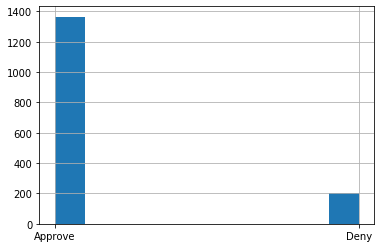

In [28]:
df_appr['status'].hist()

In [29]:
df_appr.count()

pid         1569
action      1569
start_dt    1569
end_dt      1569
status      1569
dtype: int64

In [32]:
df_txn_all[df_txn_all['action']=='REQUEST'].action.count()

1324

#### Total number of Approval+Denial records:1569 but total number of Request is 1324 means some of the data are missing.
### as per assumption#10 i am considering all rejected and approved record are the result of some request
### Number of Exchange request= number of approval+number of denial
### 1365+204=1569


In [50]:
Approval_rate=100*(df_appr[df_appr['status']=='Approve'].status.count()/(df_appr[df_appr['status']=='Approve'].status.count()+df_appr[df_appr['status']=='Deny'].status.count()))
print('Approval rate {}'.format(Approval_rate))
#print("%(key1)s and %(key2)%" % {'key1':1, 'key2':2})
Denial_rate=100*(df_appr[df_appr['status']=='Deny'].status.count()/(df_appr[df_appr['status']=='Approve'].status.count()+df_appr[df_appr['status']=='Deny'].status.count()))
print('Denial rate {}'.format(Denial_rate))

Approval rate 86.9980879541109
Denial rate 13.001912045889103


## <u>Conclusion and Insights:</u>

<ul>
<li> Compare to all the other actions, mark_updated takes more response time
 <li>It can be observed that average response time for approval is less than denial  
 <li> 15 Surgeons out of 357 has requested more than 50 times for Operating Room
<li>It is observed that the average response time is pretty high on weekends as compared to weekdays
<li>More than 50% transactions has response time less than 10 minutes 
 <li>Avergae approval rate is 87% abd average denial rate is 13%
 <li>There are few records with multiple entry of with or without Room No. ex.  4.2c9180826ba0b5ad016bb3e4a083067b
 
## <u> Future Scopes :</u>
##### 1. Day and Time wise response time analysis
##### 2. Prediction of approval or rejection chances of the request based on the past data
##### 3. Prediction of approval or rejection response time by taking the day and time as input